In [3]:
!pip install -q --upgrade pip
!pip install -q numpy pandas pyarrow openpyxl \
    scikit-learn lifelines scikit-survival matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'autograd-gamma' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'autograd-gamma'. Discussion can be found at https://github.com/pypa/pip/issues/6334
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 

In [4]:
import os, sys, gc, warnings, json
from pathlib import Path
from glob import glob

import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 100)
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_PATH = Path("/kaggle/input/telco-customer-churn-ibm-dataset/Telco_customer_churn.xlsx")

OUT_DIR = Path("data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)


In [5]:
df = pd.read_excel(DATA_PATH)
print("Loaded:", df.shape)

RENAME = {
    "CustomerID": "customer_id",
    "Tenure Months": "tenure_months",
    "Monthly Charges": "monthly_charges",
    "Total Charges": "total_charges",
    "Churn Label": "churn_label",
    "Churn Value": "churn_value",
    "Contract": "contract",
    "Internet Service": "internet_service",
    "Paperless Billing": "paperless_billing",
    "Payment Method": "payment_method",
    "Senior Citizen": "senior_citizen",
    "Gender": "gender",
    # service flags
    "Phone Service": "phone_service",
    "Multiple Lines": "multiple_lines",
    "Online Security": "online_security",
    "Online Backup": "online_backup",
    "Device Protection": "device_protection",
    "Tech Support": "tech_support",
    "Streaming TV": "streaming_tv",
    "Streaming Movies": "streaming_movies",
    "Partner": "partner",
    "Dependents": "dependents",
}
df.rename(columns={k: v for k, v in RENAME.items() if k in df.columns}, inplace=True)

for col in ("total_charges", "monthly_charges", "tenure_months"):
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

essential = [c for c in ["tenure_months", "monthly_charges", "total_charges"] if c in df.columns]
df = df.dropna(subset=essential).copy()
print("After essential drop:", df.shape)

def _clean_yes_no(series: pd.Series) -> pd.Series:
    return (
        series.astype(str)
        .str.strip()
        .str.replace("No internet service", "No", regex=False)
        .str.replace("No phone service", "No", regex=False)
    )

yn_cols = [
    "paperless_billing","partner","dependents","senior_citizen",
    "phone_service","multiple_lines","online_security","online_backup",
    "device_protection","tech_support","streaming_tv","streaming_movies",
]
for c in yn_cols:
    if c in df.columns:
        df[c] = _clean_yes_no(df[c])


Loaded: (7043, 33)
After essential drop: (7032, 33)


In [6]:
#  Survival targets  
if "churn_value" in df.columns:
    df["event"] = df["churn_value"].astype("Int64")
else:
    df["event"] = (df["churn_label"].astype(str).str.strip().str.lower() == "yes").astype("Int64")

df["duration"] = df["tenure_months"].fillna(0).astype(int).clip(lower=0)

for c in ["partner","dependents","paperless_billing"]:
    if c in df.columns:
        df[c + "_flag"] = df[c].map({"Yes": 1, "No": 0}).astype("Int64")

if "senior_citizen" in df.columns:
    df["senior_citizen_flag"] = df["senior_citizen"].map({"Yes": 1, "No": 0}).astype("Int64")

svc_cols = [
    "phone_service","multiple_lines","online_security","online_backup",
    "device_protection","tech_support","streaming_tv","streaming_movies",
]
present_svc = [c for c in svc_cols if c in df.columns]
for c in present_svc:
    df[c + "_flag"] = df[c].map({"Yes": 1, "No": 0}).astype("Int64")

flag_cols = [c + "_flag" for c in present_svc if c + "_flag" in df.columns]
df["num_services"] = df[flag_cols].sum(axis=1) if flag_cols else 0

if "payment_method" in df.columns:
    df["autopay_flag"] = df["payment_method"].astype(str).str.lower().str.contains("automatic").astype("Int64")

eps = 1e-9
avg_monthly = df["total_charges"] / df["tenure_months"].replace(0, np.nan)
df["monthly_to_total_ratio"] = df["monthly_charges"] / (avg_monthly.replace([np.inf, -np.inf], np.nan) + eps)

assert df["duration"].ge(0).all(), "Negative durations found."
print(df[["duration","event"]].describe(include="all"))
print("Event rate:", float(df["event"].mean()))
print("Tenure months (min/max):", int(df["duration"].min()), int(df["duration"].max()))


          duration     event
count  7032.000000    7032.0
mean     32.421786  0.265785
std      24.545260  0.441782
min       1.000000       0.0
25%       9.000000       0.0
50%      29.000000       0.0
75%      55.000000       1.0
max      72.000000       1.0
Event rate: 0.26578498293515357
Tenure months (min/max): 1 72


In [7]:
from pathlib import Path

OUT_DIR = Path("data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

keep = [
    "customer_id","duration","event",
    "monthly_charges","total_charges","contract","internet_service",
    "paperless_billing_flag","autopay_flag","num_services",
    "senior_citizen_flag","partner_flag","dependents_flag",
    "payment_method","gender","tenure_months","churn_label",
]
keep = [c for c in keep if c in df.columns]
df_ready = df[keep].copy()

parquet_path = "/kaggle/working/data/processed/telco_survival_ready.parquet"
csv_path = "/kaggle/working/data/processed/telco_survival_ready.csv"

df_ready.to_parquet(parquet_path, index=False) 
df_ready.to_csv(csv_path, index=False)

print(f"Saved:\n- {parquet_path}\n- {csv_path}")
print(df_ready.head(3))


Saved:
- /kaggle/working/data/processed/telco_survival_ready.parquet
- /kaggle/working/data/processed/telco_survival_ready.csv
  customer_id  duration  event  monthly_charges  total_charges  \
0  3668-QPYBK         2      1            53.85         108.15   
1  9237-HQITU         2      1            70.70         151.65   
2  9305-CDSKC         8      1            99.65         820.50   

         contract internet_service  paperless_billing_flag  autopay_flag  \
0  Month-to-month              DSL                       1             0   
1  Month-to-month      Fiber optic                       1             0   
2  Month-to-month      Fiber optic                       1             0   

   num_services  senior_citizen_flag  partner_flag  dependents_flag  \
0             3                    0             0                0   
1             1                    0             0                1   
2             5                    0             0                1   

     payment_metho

In [8]:
# Pragmatic Feature Engineering 
import numpy as np
import pandas as pd
from pathlib import Path

svc_cols = [
    "phone_service","multiple_lines","online_security","online_backup",
    "device_protection","tech_support","streaming_tv","streaming_movies",
]
present_svc = [c for c in svc_cols if c in df.columns]
flag_cols = [c + "_flag" for c in present_svc if c + "_flag" in df.columns]

_contract_map = {
    "Month-to-month": 1,
    "One year": 12,
    "Two year": 24,
}
if "contract" in df.columns:
    df["contract_term_months"] = df["contract"].map(_contract_map).astype("Int64")
    df["long_contract_flag"] = df["contract_term_months"].ge(12).astype("Int64")

def _contains(s, pat):
    return s.astype(str).str.contains(pat, case=False, na=False)

if "payment_method" in df.columns:
    df["electronic_check_flag"] = _contains(df["payment_method"], "Electronic check").astype("Int64")
    df["mailed_check_flag"]     = _contains(df["payment_method"], "Mailed check").astype("Int64")
    df["bank_auto_flag"]        = _contains(df["payment_method"], "Bank transfer (automatic)").astype("Int64")
    df["card_auto_flag"]        = _contains(df["payment_method"], "Credit card (automatic)").astype("Int64")

for col in ("paperless_billing_flag","autopay_flag"):
    if col not in df.columns:
        df[col] = pd.Series(pd.NA, index=df.index, dtype="Int64")
df["paperless_or_autopay_flag"] = ((df["paperless_billing_flag"]==1) | (df["autopay_flag"]==1)).astype("Int64")
df["paperless_and_autopay_flag"] = ((df["paperless_billing_flag"]==1) & (df["autopay_flag"]==1)).astype("Int64")

streaming_flags = [c for c in ["streaming_tv_flag","streaming_movies_flag"] if c in df.columns]
security_flags  = [c for c in ["online_security_flag","online_backup_flag","device_protection_flag","tech_support_flag"] if c in df.columns]

df["num_streaming"] = df[streaming_flags].sum(axis=1) if streaming_flags else 0
df["num_security"]  = df[security_flags].sum(axis=1)  if security_flags  else 0

df["addon_heavy_flag"] = (df["num_services"] >= 4).astype("Int64") if "num_services" in df.columns else pd.Series(pd.NA, dtype="Int64")

base_cols = [c for c in ["phone_service","multiple_lines"] if c in df.columns] 
internet_dependent = [c for c in ["online_security","online_backup","device_protection","tech_support","streaming_tv","streaming_movies"] if c in df.columns]

base_count = len(base_cols)
inet_dep_count = len(internet_dependent)

if "internet_service" in df.columns:
    has_internet = (df["internet_service"].astype(str).str.lower() != "no").astype(int)
else:
    has_internet = 1 

eligible_total = base_count + has_internet * inet_dep_count
eligible_total = eligible_total.replace(0, np.nan)

if "num_services" in df.columns:
    df["service_penetration"] = (df["num_services"] / eligible_total).fillna(0.0)
else:
    df["service_penetration"] = 0.0

eps = 1e-9
avg_monthly = df["total_charges"] / df["tenure_months"].replace(0, np.nan)
df["charge_gap_vs_avg"] = (df["monthly_charges"] - avg_monthly).replace([np.inf, -np.inf], np.nan)

if "internet_service" in df.columns and "monthly_charges" in df.columns:
    grp = df.groupby("internet_service")["monthly_charges"]
    mean_by_svc = grp.transform("mean")
    std_by_svc  = grp.transform("std").replace(0, np.nan)
    df["mc_z_by_service"] = ((df["monthly_charges"] - mean_by_svc) / (std_by_svc + eps)).fillna(0.0)

    df["mc_pct_by_service"] = grp.transform(lambda s: s.rank(pct=True, method="average"))

    q75_map = df.groupby("internet_service")["monthly_charges"].quantile(0.75).to_dict()
    df["high_price_by_service_flag"] = (df["monthly_charges"] >= df["internet_service"].map(q75_map)).astype("Int64")
else:
    df["mc_z_by_service"] = 0.0
    df["mc_pct_by_service"] = 0.5
    df["high_price_by_service_flag"] = pd.Series(pd.NA, dtype="Int64")

df["long_contract_and_autopay_flag"] = (
    (df.get("long_contract_flag", 0)==1) & (df.get("autopay_flag", 0)==1)
).astype("Int64")

df["fiber_and_high_price_flag"] = (
    (df.get("internet_service","").astype(str).str.lower()=="fiber optic") &
    (df.get("high_price_by_service_flag", 0)==1)
).astype("Int64")

for c in ("partner_flag","dependents_flag"):
    if c not in df.columns:
        df[c] = pd.Series(pd.NA, index=df.index, dtype="Int64")

def _household_type(row):
    p, d = row["partner_flag"], row["dependents_flag"]
    if p==1 and d==1:   return "family"
    if p==1 and d!=1:   return "couple_no_kids"
    if p!=1 and d==1:   return "single_with_kids"
    return "single"

df["household_type"] = df[["partner_flag","dependents_flag"]].apply(_household_type, axis=1)

if "senior_citizen_flag" in df.columns and "tech_support_flag" in df.columns:
    df["senior_no_support_flag"] = ((df["senior_citizen_flag"]==1) & (df["tech_support_flag"]==0)).astype("Int64")

OUT_DIR = Path("data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

add_keep = [
    "customer_id","duration","event",
    "monthly_charges","total_charges","contract","internet_service",
    "paperless_billing_flag","autopay_flag","num_services",
    "senior_citizen_flag","partner_flag","dependents_flag",
    "payment_method","gender",
    # engineered features
    "contract_term_months","long_contract_flag","long_contract_and_autopay_flag",
    "electronic_check_flag","mailed_check_flag","bank_auto_flag","card_auto_flag",
    "paperless_or_autopay_flag","paperless_and_autopay_flag",
    "num_streaming","num_security","addon_heavy_flag",
    "service_penetration","charge_gap_vs_avg","monthly_to_total_ratio",
    "mc_z_by_service","mc_pct_by_service","high_price_by_service_flag",
    "fiber_and_high_price_flag","household_type",
    "tenure_months","churn_label",
]
add_keep = [c for c in add_keep if c in df.columns]

df_ready_v2 = df[add_keep].copy()

leakage_cols = [c for c in ["tenure_months","churn_label"] if c in df_ready_v2.columns]
df_ready_model = df_ready_v2.drop(columns=leakage_cols, errors="ignore")


In [9]:
# KM Curves + Log-Rank Tests
import os
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test

warnings.filterwarnings("ignore")

assert {"duration","event"}.issubset(df.columns), "Need 'duration' & 'event' columns."

# Output paths
OUT_DIR = Path("outputs/section3")
PLOTS_DIR = OUT_DIR / "plots"
TABLES_DIR = OUT_DIR / "tables"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

def _largest_drops(kmf: KaplanMeierFitter, top_k=3):
    """Return top-k (time, drop_size) points with the steepest S(t) decreases."""
    sf = kmf.survival_function_.copy()
    sf.columns = ["S"]
    sf["S_prev"] = sf["S"].shift(1)
    sf["drop"] = (sf["S_prev"] - sf["S"]).fillna(0.0)
    drops = sf[sf["drop"] > 0].sort_values("drop", ascending=False).head(top_k)
    return list(zip(drops.index.astype(float), drops["drop"].round(4)))

def _plot_overall_km(df: pd.DataFrame):
    kmf = KaplanMeierFitter()
    T, E = df["duration"].astype(int).values, df["event"].astype(int).values

    fig, ax = plt.subplots(figsize=(7.5, 5.0), dpi=150)
    kmf.fit(T, event_observed=E, label="All customers")
    kmf.plot(ax=ax, ci_show=True, show_censors=True)
    ax.set_title("Kaplan–Meier Survival Curve — All Customers")
    ax.set_xlabel("Tenure (months)")
    ax.set_ylabel("Survival probability (not churned)")
    ax.grid(alpha=0.25)

    med = kmf.median_survival_time_
    if np.isfinite(med):
        ax.axhline(0.5, ls="--", lw=1, alpha=0.7)
        ax.axvline(med, ls="--", lw=1, alpha=0.7)
        ax.text(med, 0.52, f" Median ≈ {med:.1f} mo", ha="left", va="bottom")

    drops = _largest_drops(kmf, top_k=3)
    for i,(t, d) in enumerate(drops, start=1):
        ax.annotate(f"▲ drop {d:.2%} @ {t:.0f}m", xy=(t, kmf.survival_function_.iloc[kmf.survival_function_.index.get_indexer([t], method='nearest')[0], 0]),
                    xytext=(t+2, 0.1 + 0.07*i), arrowprops=dict(arrowstyle="->", lw=0.7), fontsize=8)

    fig.tight_layout()
    fig_path = PLOTS_DIR / "km_overall.png"
    fig.savefig(fig_path, bbox_inches="tight")
    plt.close(fig)

    base_summary = {
        "n_customers": len(T),
        "events": int(E.sum()),
        "censored": int((1 - E).sum()),
        "event_rate": float(E.mean()),
        "median_survival_months": float(med) if np.isfinite(med) else np.nan,
        "top_drops": "; ".join([f"{t:.0f}m:{d:.2%}" for t, d in drops]) if drops else ""
    }
    return base_summary, kmf

def _plot_segmented_km(df: pd.DataFrame, by: str, min_count=50):
    """Plot KM curves by a categorical column; return per-group summary + pairwise log-rank p-values."""
    assert by in df.columns, f"Column '{by}' not found."
    # Clean small groups
    counts = df[by].value_counts(dropna=False)
    keep_levels = counts[counts >= min_count].index.tolist()
    dfx = df[df[by].isin(keep_levels)].copy()

    if dfx.empty or len(keep_levels) < 2:
        return None, None, None 

    # Plot curves
    fig, ax = plt.subplots(figsize=(7.5, 5.0), dpi=150)
    summaries = []
    for level, g in dfx.groupby(by):
        kmf = KaplanMeierFitter()
        T, E = g["duration"].astype(int).values, g["event"].astype(int).values
        label = f"{level} (n={len(g)})"
        kmf.fit(T, event_observed=E, label=label)
        kmf.plot(ax=ax, ci_show=False, show_censors=True)
        med = kmf.median_survival_time_
        drops = _largest_drops(kmf, top_k=2)
        summaries.append({
            by: level,
            "n": len(g),
            "events": int(E.sum()),
            "event_rate": float(E.mean()),
            "median_survival_months": float(med) if np.isfinite(med) else np.nan,
            "top_drops": "; ".join([f"{t:.0f}m:{d:.2%}" for t, d in drops]) if drops else ""
        })

    ax.set_title(f"Kaplan–Meier by {by}")
    ax.set_xlabel("Tenure (months)")
    ax.set_ylabel("Survival probability")
    ax.grid(alpha=0.25)
    fig.tight_layout()
    fig_path = PLOTS_DIR / f"km_by_{by}.png"
    fig.savefig(fig_path, bbox_inches="tight")
    plt.close(fig)

    lr = pairwise_logrank_test(
        dfx["duration"].astype(int),
        dfx[by].astype(str),
        dfx["event"].astype(int),
        p_adjust="holm"
    )
    p_table = lr.summary.reset_index(names=["group_a", "group_b"]).rename(columns={"p":"p_value_holm"})
    p_table.to_csv(TABLES_DIR / f"logrank_pairwise_{by}.csv", index=False)

    group_df = pd.DataFrame(summaries).sort_values("median_survival_months", ascending=False)
    group_df.to_csv(TABLES_DIR / f"km_summary_by_{by}.csv", index=False)

    return group_df, p_table, fig_path

overall_stats, overall_kmf = _plot_overall_km(df)
pd.DataFrame([overall_stats]).to_csv(TABLES_DIR / "km_overall_summary.csv", index=False)

print("Overall KM summary")
display(pd.DataFrame([overall_stats]))

segments = [
    ("contract", 40),           
    ("internet_service", 40),      
    ("senior_citizen_flag", 40),  
    ("autopay_flag", 40),         
]

for col, min_n in segments:
    if col in df.columns:
        print(f"\n=== {col}: KM + Log-Rank ===")
        result = _plot_segmented_km(df, by=col, min_count=min_n)
        if result[0] is None:
            print(f"Skipped {col}: not enough groups or samples.")
            continue
        group_df, p_table, fig_path = result
        display(group_df.head(len(group_df)))
        display(p_table)
        print(f"Saved plot -> {fig_path}")
    else:
        print(f"Column '{col}' not found; skipping.")

if "contract" in df.columns:
    km_contract = pd.read_csv(TABLES_DIR / "km_summary_by_contract.csv")
    lookup = dict(zip(km_contract["contract"].astype(str), km_contract["median_survival_months"]))
    if all(k in lookup for k in ["Month-to-month","Two year"]):
        gap = lookup["Two year"] - lookup["Month-to-month"]
        if np.isfinite(gap) and gap > 10:
            print(f"\n[Playbook Signal] Large median gap between Two year and Month-to-month (~{gap:.1f} months).")
            mm_row = df[df["contract"]=="Month-to-month"]
            if len(mm_row) > 30:
                kmf_tmp = KaplanMeierFitter().fit(mm_row["duration"], mm_row["event"])
                drops = _largest_drops(kmf_tmp, top_k=1)
                if drops:
                    t_star, d_star = drops[0]
                    print(f"   Earliest sharp drop for Month-to-month: ~{t_star:.0f} months (drop {d_star:.2%}).")
                    print("   → Consider ‘early renewal bonus’ or ‘light lock-in’ offers before this month.")
 

Overall KM summary


,n_customers,events,censored,event_rate,median_survival_months,top_drops
0,7032,1869,5163,0.265785,NaN,1m:5.40%; 2m:1.81%; 3m:1.41%



=== contract: KM + Log-Rank ===


,contract,n,events,event_rate,median_survival_months,top_drops
0,Month-to-month,3875,1655,0.427097,35.0,1m:9.81%; 69m:3.55%
1,One year,1472,166,0.112772,NaN,72m:7.58%; 70m:4.81%
2,Two year,1685,48,0.028487,NaN,72m:1.10%; 71m:1.00%


,group_a,group_b,test_statistic,p_value_holm,-log2(p)
0,Month-to-month,One year,926.064559,2.117327e-203,673.269159
1,Month-to-month,Two year,1550.510307,0.000000e+00,inf
2,One year,Two year,256.217767,1.145448e-57,189.153989


Saved plot -> outputs/section3/plots/km_by_contract.png

=== internet_service: KM + Log-Rank ===


,internet_service,n,events,event_rate,median_survival_months,top_drops
1,Fiber optic,3096,1297,0.418928,65.0,1m:6.56%; 2m:2.42%
0,DSL,2416,459,0.189983,NaN,1m:4.93%; 2m:1.85%
2,No,1520,113,0.074342,NaN,1m:3.82%; 56m:0.53%


,group_a,group_b,test_statistic,p_value_holm,-log2(p)
0,DSL,Fiber optic,227.174973,2.462919e-51,168.117964
1,DSL,No,80.317890,3.187699e-19,61.444119
2,Fiber optic,No,374.157435,2.328119e-83,274.500867


Saved plot -> outputs/section3/plots/km_by_internet_service.png

=== senior_citizen_flag: KM + Log-Rank ===


,senior_citizen_flag,n,events,event_rate,median_survival_months,top_drops
1,1,1142,476,0.416813,65.0,1m:6.48%; 2m:2.66%
0,0,5890,1393,0.236503,NaN,1m:5.20%; 2m:1.64%


,group_a,group_b,test_statistic,p_value_holm,-log2(p)
0,0,1,109.489693,1.267619e-25,82.706081


Saved plot -> outputs/section3/plots/km_by_senior_citizen_flag.png

=== autopay_flag: KM + Log-Rank ===


,autopay_flag,n,events,event_rate,median_survival_months,top_drops
0,0,3969,1379,0.347443,62.0,1m:8.82%; 2m:2.58%
1,1,3063,490,0.159974,NaN,70m:1.20%; 66m:1.01%


,group_a,group_b,test_statistic,p_value_holm,-log2(p)
0,0,1,624.495333,7.871259e-138,455.449483


Saved plot -> outputs/section3/plots/km_by_autopay_flag.png


In [10]:
# Setup, targets, split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sksurv.util import Surv
from sklearn.model_selection import train_test_split

assert 'df_ready_model' in globals(), "df_ready_model not found. Run the prep/FE cells first."

TARGET_DURATION = "duration"
TARGET_EVENT    = "event"
RANDOM_STATE    = 42

drop_cols = [c for c in [TARGET_DURATION, TARGET_EVENT, "customer_id", "customerID"] if c in df_ready_model.columns]
X_df = df_ready_model.drop(columns=drop_cols).copy()
y_struct = Surv.from_arrays(
    event=df_ready_model[TARGET_EVENT].astype(bool).values,
    time=df_ready_model[TARGET_DURATION].astype(float).values
)

cat_cols = X_df.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X_df.select_dtypes(exclude=["object", "category"]).columns.tolist()

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y_struct, test_size=0.25, random_state=RANDOM_STATE, stratify=y_struct["event"]
)


In [11]:
# Preprocess builder + variance/duplicate filter
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

def make_ohe():
    """Safe OneHotEncoder with binary-drop + rare-level coalescing when available."""
    try:
        return OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse_output=False, min_frequency=0.01)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse=False)

def make_preprocess(cat_cols, num_cols):
    num_tf = Pipeline([("impute", SimpleImputer(strategy="median")), ("scale", StandardScaler())])
    cat_tf = Pipeline([("impute", SimpleImputer(strategy="most_frequent")), ("ohe", make_ohe())])
    return ColumnTransformer([("num", num_tf, num_cols), ("cat", cat_tf, cat_cols)], remainder="drop")

def get_ohe_feature_names(prep, cat_cols, num_cols):
    """Robustly recover feature names after ColumnTransformer+OHE."""
    cat_pipe = prep.named_transformers_.get("cat", None)
    ohe = None if cat_pipe is None else getattr(cat_pipe, "named_steps", {}).get("ohe", None)
    if ohe is None:
        return np.array(num_cols, dtype=object)
    try:
        cat_names = ohe.get_feature_names_out(cat_cols)
    except Exception:
        cat_names = ohe.get_feature_names(cat_cols)
    return np.r_[num_cols, cat_names]

class ColumnFilterByVarianceAndDuplicates(BaseEstimator, TransformerMixin):
    """
    Drops zero-variance columns and exact duplicate columns after preprocessing.
    Stores keep_idx_ so we can later recover feature names used by Cox.
    """
    def __init__(self, round_decimals=12):
        self.round_decimals = round_decimals

    def fit(self, X, y=None):
        X = np.asarray(X)
        stds = X.std(axis=0)
        const_mask = stds > 0
        X_nz = X[:, const_mask]
        Xr = np.round(X_nz, self.round_decimals)
        _, uniq_idx = np.unique(Xr, axis=1, return_index=True)
        uniq_idx = np.sort(uniq_idx)
        keep_idx = np.flatnonzero(const_mask)[uniq_idx]
        self.keep_idx_ = keep_idx
        return self

    def transform(self, X):
        X = np.asarray(X)
        return X[:, self.keep_idx_]


In [12]:
# CoxPH + HRs
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

prep_cox   = make_preprocess(cat_cols, num_cols)
colfilter  = ColumnFilterByVarianceAndDuplicates()
cox_alpha  = 1.0  

cox_pipe = Pipeline([
    ("prep",      prep_cox),
    ("colfilter", colfilter),
    ("model",     CoxPHSurvivalAnalysis(alpha=cox_alpha))
])

cox_pipe.fit(X_train_df, y_train)

Xt_cox_test = cox_pipe.named_steps["prep"].transform(X_test_df)
Xt_cox_test = cox_pipe.named_steps["colfilter"].transform(Xt_cox_test)
risk_test_cox = cox_pipe.named_steps["model"].predict(Xt_cox_test)
cindex_cox = concordance_index_censored(y_test["event"], y_test["time"], risk_test_cox)[0]
print(f"[CoxPH] Test C-index: {cindex_cox:.4f} (alpha={cox_alpha})")

all_names   = get_ohe_feature_names(prep_cox, cat_cols, num_cols)
keep_idx    = cox_pipe.named_steps["colfilter"].keep_idx_
cox_names   = all_names[keep_idx]
coef_series = pd.Series(cox_pipe.named_steps["model"].coef_, index=cox_names)
hr = np.exp(coef_series).rename("hazard_ratio").to_frame()
hr["coef"] = coef_series
hr_sorted = hr.reindex(hr["hazard_ratio"].sort_values(ascending=False).index)

display(hr_sorted.head(25))
display(hr_sorted.tail(25))


[CoxPH] Test C-index: 0.9270 (alpha=1.0)


,hazard_ratio,coef
num_services,4.265631,1.450590
internet_service_Fiber optic,2.326913,0.844542
mc_z_by_service,2.274688,0.821843
contract_One year,1.522291,0.420217
monthly_charges,1.490879,0.399366
household_type_couple_no_kids,1.308071,0.268554
household_type_single_with_kids,1.220495,0.199257
fiber_and_high_price_flag,1.195153,0.178274
high_price_by_service_flag,1.180104,0.165603
monthly_to_total_ratio,1.169809,0.156840


,hazard_ratio,coef
electronic_check_flag,1.033271,0.032730
payment_method_Credit card (automatic),1.019003,0.018825
payment_method_Electronic check,1.015612,0.015491
paperless_and_autopay_flag,0.991851,-0.008182
long_contract_and_autopay_flag,0.987972,-0.012101
paperless_or_autopay_flag,0.983338,-0.016802
senior_citizen_flag,0.981469,-0.018705
payment_method_Bank transfer (automatic),0.929947,-0.072628
gender_Male,0.923873,-0.079180
household_type_single,0.902081,-0.103051


In [13]:
# PH diagnostics
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from scipy.linalg import qr

Xt_cox_train = cox_pipe.named_steps["prep"].transform(X_train_df)
Xt_cox_train = cox_pipe.named_steps["colfilter"].transform(Xt_cox_train)
cox_names     = get_ohe_feature_names(cox_pipe.named_steps["prep"], cat_cols, num_cols)[cox_pipe.named_steps["colfilter"].keep_idx_]

def full_rank_keep_idx(X, tol=1e-10, round_decimals=12):
    Xr = np.round(np.asarray(X), round_decimals)
    Q, R, piv = qr(Xr, mode="economic", pivoting=True)
    diag = np.abs(np.diag(R))
    rank = int((diag > tol).sum())
    return np.sort(piv[:rank])

keep_fr   = full_rank_keep_idx(Xt_cox_train)
Xt_train_fr = Xt_cox_train[:, keep_fr]
feat_fr     = cox_names[keep_fr]

lifelines_train = pd.DataFrame(Xt_train_fr, columns=feat_fr, index=X_train_df.index)
lifelines_train.insert(0, TARGET_DURATION, y_train["time"])
lifelines_train.insert(1, TARGET_EVENT,    y_train["event"].astype(int))

cph_ll = CoxPHFitter(penalizer=0.5)
cph_ll.fit(lifelines_train, duration_col=TARGET_DURATION, event_col=TARGET_EVENT, show_progress=False)

ph = proportional_hazard_test(cph_ll, lifelines_train, time_transform='rank')

p_global = None
try:
    if hasattr(ph, "summary") and isinstance(ph.summary, pd.DataFrame) and "p" in ph.summary.columns and "global" in ph.summary.index:
        p_global = float(ph.summary.loc["global", "p"])
    elif hasattr(ph, "p_value"):
        pv = np.asarray(ph.p_value)
        if pv.ndim == 0:
            p_global = float(pv)
except Exception:
    p_global = None

print(f"[PH] Global p-value: {p_global if p_global is not None else 'not available in this lifelines version.'}")

if hasattr(ph, "summary") and isinstance(ph.summary, pd.DataFrame) and "p" in ph.summary.columns:
    common = [f for f in feat_fr if f in ph.summary.index]
    violators = ph.summary.loc[common, "p"].sort_values()
    violators = violators[violators < 0.05]
    print(f"Potential PH violators (p<0.05): {len(violators)}")
    display(violators.to_frame("p_value").head(30))
else:
    print("Per-variable PH p-values not available; skipping violators table.")


[PH] Global p-value: not available in this lifelines version.
Potential PH violators (p<0.05): 6


,p_value
dependents_flag,0.011047
num_streaming,0.015259
contract_term_months,0.019969
num_services,0.034943
addon_heavy_flag,0.037730
mailed_check_flag,0.038011


In [14]:
# FAST GBM CONFIG
SEARCH_MODE = "fast"    
ETA_MODE    = "instant" 

if SEARCH_MODE == "fast":
    N_ITER = 16
    N_SPLITS = 3
    EST_RANGE = (100, 400)        
    LR_LOW, LR_SPAN = 0.03, 0.12   
    SUB_LOW, SUB_SPAN = 0.7, 0.3    
    MAX_DEPTH = (1, 3)
elif SEARCH_MODE == "turbo":
    N_ITER = 8
    N_SPLITS = 2
    EST_RANGE = (100, 250)
    LR_LOW, LR_SPAN = 0.05, 0.10   
    SUB_LOW, SUB_SPAN = 0.8, 0.2    
    MAX_DEPTH = (1, 2)
else:
    raise ValueError("SEARCH_MODE must be 'fast' or 'turbo'")


In [15]:
# PRE-ENCODE TRAIN/TEST
from sklearn.model_selection import KFold
import numpy as np

prep_gbm_fast = make_preprocess(cat_cols, num_cols)
prep_gbm_fast.fit(X_train_df)

X_train_enc = prep_gbm_fast.transform(X_train_df)
X_test_enc  = prep_gbm_fast.transform(X_test_df)

cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
folds = list(cv.split(X_train_enc))
n_samples, n_features = X_train_enc.shape



In [16]:
# RUNTIME ETA
import os, time
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

def fmt_minutes(sec):
    mins = sec / 60.0
    return (f"{mins:.1f} min") if mins < 120 else (f"{mins/60:.1f} hr")

total_tasks = N_ITER * N_SPLITS
effective_workers = max(1, min(os.cpu_count() or 1, total_tasks))

if ETA_MODE == "instant":
    DEPTH_FACTOR = 1.0 * ((MAX_DEPTH[0] + MAX_DEPTH[1]) / 2.0)   
    TREES_PER_CFG = (EST_RANGE[0] + EST_RANGE[1]) / 2.0
    KERNEL = 0.0012  # conservative
    per_fold_sec = KERNEL * (n_samples / 10000.0) * TREES_PER_CFG * DEPTH_FACTOR
    OVERHEAD = 1.15
    est_wall_sec = OVERHEAD * (total_tasks * per_fold_sec) / effective_workers
    print(f"[GBM-FAST][ETA instant] ~{fmt_minutes(est_wall_sec)} "
          f"(tasks={total_tasks}, workers≈{effective_workers}, "
          f"samples={n_samples}, trees≈{int(TREES_PER_CFG)}, depth≈{int(DEPTH_FACTOR)})")

elif ETA_MODE == "probe":
    PROBE = dict(n_estimators=100, learning_rate=0.10, max_depth=1,
                 min_samples_split=4, min_samples_leaf=2,
                 subsample=0.8, max_features="sqrt")
    tr_idx, _ = folds[0]
    t0 = time.perf_counter()
    _probe = GradientBoostingSurvivalAnalysis(loss="coxph", random_state=RANDOM_STATE, **PROBE)
    _probe.fit(X_train_enc[tr_idx], y_train[tr_idx])
    t1 = time.perf_counter()
    per_fold_sec = t1 - t0
    OVERHEAD = 1.15
    est_wall_sec = OVERHEAD * (total_tasks * per_fold_sec) / effective_workers
    print(f"[GBM-FAST][ETA probe] ~{fmt_minutes(est_wall_sec)} "
          f"(tasks={total_tasks}, workers≈{effective_workers}, per-fold≈{per_fold_sec:.2f}s)")
else:
    raise ValueError("ETA_MODE must be 'instant' or 'probe'")


[GBM-FAST][ETA instant] ~0.1 min (tasks=48, workers≈4, samples=5274, trees≈250, depth≈2)


In [17]:
# COMPACT SEARCH
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
import numpy as np, time

rng = np.random.default_rng(RANDOM_STATE)

def sample_params():
    return {
        "n_estimators":      int(rng.integers(EST_RANGE[0], EST_RANGE[1] + 1)),
        "learning_rate":     float(LR_LOW + rng.random() * LR_SPAN),
        "max_depth":         int(rng.integers(MAX_DEPTH[0], MAX_DEPTH[1] + 1)),
        "min_samples_split": int(rng.integers(2, 16)),
        "min_samples_leaf":  int(rng.integers(1, 12)),
        "subsample":         float(SUB_LOW + rng.random() * SUB_SPAN),
        "max_features":      rng.choice(["sqrt", "log2"])
    }

candidates = [sample_params() for _ in range(N_ITER)]

best_score, best_params = -np.inf, None
start = time.perf_counter()
for i, p in enumerate(candidates, 1):
    est = GradientBoostingSurvivalAnalysis(loss="coxph", random_state=RANDOM_STATE, **p)
    scores = []
    for tr_idx, te_idx in folds:
        est.fit(X_train_enc[tr_idx], y_train[tr_idx])
        risk = est.predict(X_train_enc[te_idx])
        s = concordance_index_censored(y_train[te_idx]["event"], y_train[te_idx]["time"], risk)[0]
        scores.append(s)
    mean_s = float(np.mean(scores))
    if mean_s > best_score:
        best_score, best_params = mean_s, p
    print(f"[{i}/{N_ITER}] CV C-index={mean_s:.4f}  params={p}")
elapsed = time.perf_counter() - start
print(f"[GBM-FAST] Search finished in {fmt_minutes(elapsed)}. Best CV C-index={best_score:.4f}")
print("[GBM-FAST] Best params:", best_params)


[1/16] CV C-index=0.9343  params={'n_estimators': 126, 'learning_rate': 0.08266541277024628, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 10, 'subsample': 0.9092104087178091, 'max_features': 'sqrt'}
[2/16] CV C-index=0.9448  params={'n_estimators': 128, 'learning_rate': 0.1470746821964107, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 8, 'subsample': 0.7384340898026637, 'max_features': 'log2'}
[3/16] CV C-index=0.9467  params={'n_estimators': 352, 'learning_rate': 0.07449576290790974, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 11, 'subsample': 0.8931595360241993, 'max_features': 'sqrt'}
[4/16] CV C-index=0.9431  params={'n_estimators': 347, 'learning_rate': 0.08320970385927973, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.7191451768312526, 'max_features': 'log2'}
[5/16] CV C-index=0.9616  params={'n_estimators': 358, 'learning_rate': 0.10579972789464778, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_

In [18]:
# REFIT PIPELINE + ALIASES
from sklearn.pipeline import Pipeline

gbm_refit = GradientBoostingSurvivalAnalysis(loss="coxph", random_state=RANDOM_STATE, **best_params)
best_gbm_pipe = Pipeline([("prep", make_preprocess(cat_cols, num_cols)), ("model", gbm_refit)])
best_gbm_pipe.fit(X_train_df, y_train)

best_gbm = best_gbm_pipe
Xt_gbm_test = best_gbm.named_steps["prep"].transform(X_test_df)

from sksurv.metrics import concordance_index_censored
risk_test_gbm = best_gbm.named_steps["model"].predict(Xt_gbm_test)
cindex_gbm = concordance_index_censored(y_test["event"], y_test["time"], risk_test_gbm)[0]
print(f"[GBM-FAST] Test C-index: {cindex_gbm:.4f}")

[GBM-FAST] Test C-index: 0.9629


In [19]:
# 5 — A-Grade Evaluation (Discrimination, Calibration, Impact)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sksurv.metrics import concordance_index_censored, brier_score

t_min = max(1.0, np.percentile(y_test["time"], 1))
t_max = float(np.percentile(y_test["time"], 90))
TIMES = np.linspace(t_min, t_max, 40) 

print(f"[Eval] Calibration time window: {t_min:.0f} → {t_max:.0f} (units match 'duration')")


[Eval] Calibration time window: 1 → 69 (units match 'duration')


In [20]:
# 5.1 Discrimination — Consolidated C-Index Report

def _safe_cindex(risk_scores, y_struct):
    return float(concordance_index_censored(y_struct["event"], y_struct["time"], risk_scores)[0])

results_discrimination = {}

if "risk_test_cox" in globals():
    results_discrimination["CoxPH_CIndex"] = float(cindex_cox) if "cindex_cox" in globals() else _safe_cindex(risk_test_cox, y_test)
else:
    Xt_cox_test_eval = cox_pipe.named_steps["prep"].transform(X_test_df)
    Xt_cox_test_eval = cox_pipe.named_steps["colfilter"].transform(Xt_cox_test_eval)
    risk_test_cox = cox_pipe.named_steps["model"].predict(Xt_cox_test_eval)
    results_discrimination["CoxPH_CIndex"] = _safe_cindex(risk_test_cox, y_test)

if "risk_test_gbm" in globals():
    results_discrimination["GBM_CIndex"] = float(cindex_gbm) if "cindex_gbm" in globals() else _safe_cindex(risk_test_gbm, y_test)
else:
    Xt_gbm_test_eval = best_gbm.named_steps["prep"].transform(X_test_df)
    risk_test_gbm    = best_gbm.named_steps["model"].predict(Xt_gbm_test_eval)
    results_discrimination["GBM_CIndex"] = _safe_cindex(risk_test_gbm, y_test)

print("\n[Discrimination — C-Index]")
for k, v in results_discrimination.items():
    print(f"  {k:>12}: {v:.4f}")



[Discrimination — C-Index]
  CoxPH_CIndex: 0.9270
    GBM_CIndex: 0.9629



[Calibration — Integrated Brier Score]
  CoxPH IBS: 0.0333
  GBM   IBS: 0.0344


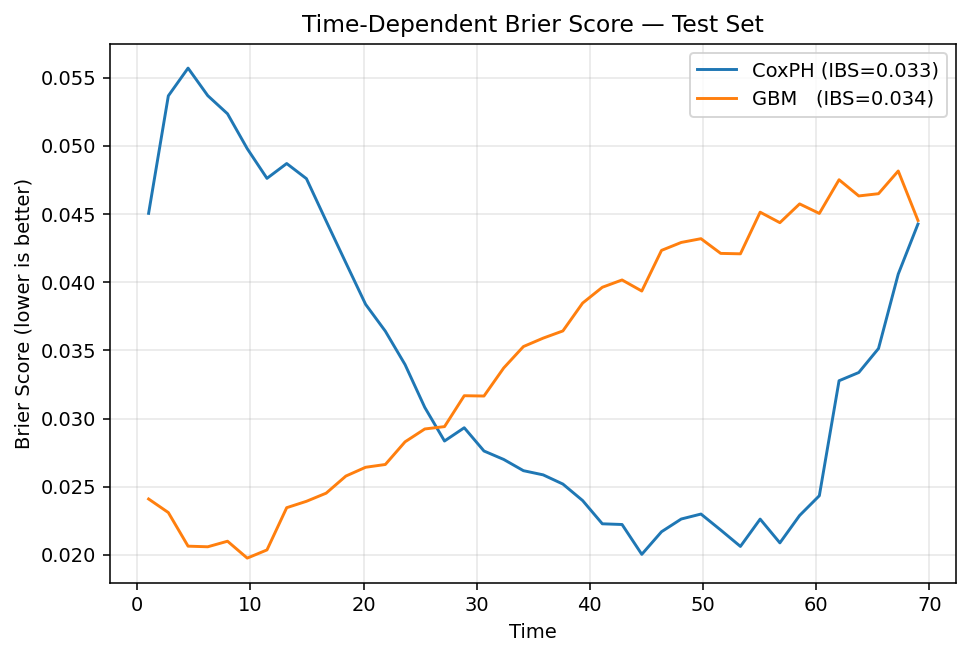

In [23]:
# 5.2 Calibration — Time-Dependent Brier Score (+ Integrated Brier)
from sksurv.metrics import brier_score

def sf_to_matrix(sf_list, times):
    """
    Convert a list of StepFunction survival curves into an array of shape
    (n_samples, n_times) with S(t) evaluated at each time.
    """
    times = np.asarray(times, dtype=float)
    mat = np.empty((len(sf_list), len(times)), dtype=float)
    for i, sf in enumerate(sf_list):
        mat[i, :] = [float(sf(t)) for t in times]
    return mat

est_cox = sf_to_matrix(sf_cox, TIMES) 
est_gbm = sf_to_matrix(sf_gbm, TIMES)

times_brier_cox, brier_cox = brier_score(y_train, y_test, est_cox, TIMES)
times_brier_gbm, brier_gbm = brier_score(y_train, y_test, est_gbm, TIMES)

def integrated_brier_score(times, scores):
    times = np.asarray(times, dtype=float)
    scores = np.asarray(scores, dtype=float)
    if len(times) < 2 or (times.max() - times.min()) <= 0:
        return np.nan
    return float(np.trapz(scores, times) / (times.max() - times.min()))

ibs_cox = integrated_brier_score(times_brier_cox, brier_cox)
ibs_gbm = integrated_brier_score(times_brier_gbm, brier_gbm)

print("\n[Calibration — Integrated Brier Score]")
print(f"  CoxPH IBS: {ibs_cox:.4f}")
print(f"  GBM   IBS: {ibs_gbm:.4f}")

plt.figure(figsize=(7.8, 5.0), dpi=140)
plt.plot(times_brier_cox, brier_cox, label=f"CoxPH (IBS={ibs_cox:.3f})")
plt.plot(times_brier_gbm, brier_gbm, label=f"GBM   (IBS={ibs_gbm:.3f})")
plt.xlabel("Time")
plt.ylabel("Brier Score (lower is better)")
plt.title("Time-Dependent Brier Score — Test Set")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [24]:
# 5.3 Business Impact — Lift@k (deciles) at a chosen horizon

HORIZON_MONTHS = 6  # you can also try 12 as a second scenario

def survival_at_h(sf_list, h):
    """Return array of S(h) for each survival function in sf_list."""
    out = np.empty(len(sf_list), dtype=float)
    for i, sf in enumerate(sf_list):
        out[i] = float(sf(h))
    return out

def lift_by_decile(risks, labels, k=10):
    """
    risks: higher means more likely to churn by H
    labels: binary 0/1 for event by H (must be defined for all rows passed here)
    Returns: DataFrame with decile, lift, rate, count
    """
    n = len(risks)
    order = np.argsort(-risks)  
    risks_sorted = risks[order]
    y_sorted = labels[order].astype(int)

    base = y_sorted.mean() if n > 0 else np.nan

    bins = np.array_split(np.arange(n), k)
    rows = []
    for i, idx in enumerate(bins, start=1):
        if len(idx) == 0: 
            rate = np.nan
            lift = np.nan
            cnt  = 0
        else:
            rate = y_sorted[idx].mean()
            lift = (rate / base) if (base > 0) else np.nan
            cnt  = len(idx)
        rows.append({"decile": i, "count": cnt, "rate": rate, "lift": lift})
    return pd.DataFrame(rows)


event_by_H = (y_test["event"] & (y_test["time"] <= HORIZON_MONTHS))
known_survive_past_H = (~y_test["event"]) & (y_test["time"] >= HORIZON_MONTHS)
keep_mask = event_by_H | known_survive_past_H

sf_cox_test = _predict_survival_functions(cox_pipe,  X_test_df[keep_mask])
sf_gbm_test = _predict_survival_functions(best_gbm, X_test_df[keep_mask])

S_cox_H  = survival_at_h(sf_cox_test, HORIZON_MONTHS)
S_gbm_H  = survival_at_h(sf_gbm_test, HORIZON_MONTHS)
risk_cox = 1.0 - S_cox_H
risk_gbm = 1.0 - S_gbm_H

yH = event_by_H[keep_mask].astype(int)  # ground truth by H
assert risk_cox.shape[0] == yH.shape[0] == risk_gbm.shape[0], "Shape mismatch in Lift@k inputs."

lift_cox = lift_by_decile(risk_cox, yH, k=10)
lift_gbm = lift_by_decile(risk_gbm, yH, k=10)

print(f"[Impact — Lift@k] Horizon = {HORIZON_MONTHS} months")
print(f"Evaluated population (known outcome by H): {keep_mask.sum()} of {len(keep_mask)}")

display(lift_cox.head(10).assign(model="CoxPH"))
display(lift_gbm.head(10).assign(model="GBM"))

[Impact — Lift@k] Horizon = 6 months
Evaluated population (known outcome by H): 1341 of 1758


,decile,count,rate,lift,model
0,1,135,0.888889,5.814634,CoxPH
1,2,134,0.380597,2.489661,CoxPH
2,3,134,0.194030,1.269239,CoxPH
3,4,134,0.059701,0.390535,CoxPH
4,5,134,0.000000,0.000000,CoxPH
5,6,134,0.000000,0.000000,CoxPH
6,7,134,0.000000,0.000000,CoxPH
7,8,134,0.000000,0.000000,CoxPH
8,9,134,0.000000,0.000000,CoxPH
9,10,134,0.000000,0.000000,CoxPH


,decile,count,rate,lift,model
0,1,135,1.000000,6.541463,GBM
1,2,134,0.470149,3.075464,GBM
2,3,134,0.037313,0.244084,GBM
3,4,134,0.014925,0.097634,GBM
4,5,134,0.000000,0.000000,GBM
5,6,134,0.000000,0.000000,GBM
6,7,134,0.000000,0.000000,GBM
7,8,134,0.000000,0.000000,GBM
8,9,134,0.000000,0.000000,GBM
9,10,134,0.000000,0.000000,GBM


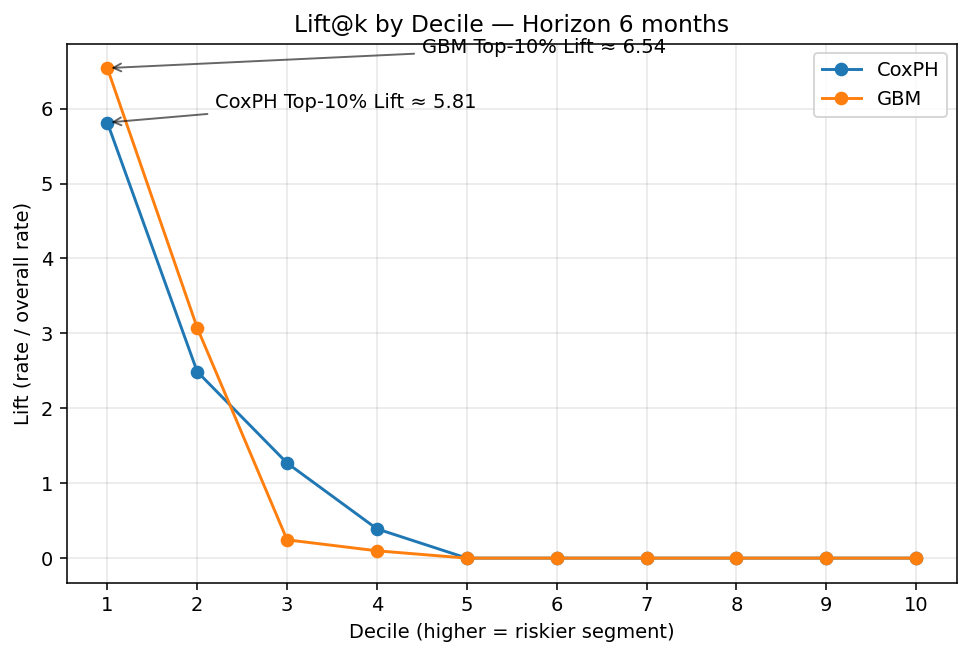

In [25]:
# 5.4 Lift@k Visualization (Top-Decile Emphasis)

def plot_lift_compare(lift_df_a, lift_df_b, label_a="CoxPH", label_b="GBM", horizon=HORIZON_MONTHS):
    fig, ax = plt.subplots(figsize=(8.2, 5.0), dpi=140)
    ax.plot(lift_df_a["decile"], lift_df_a["lift"], marker="o", label=label_a)
    ax.plot(lift_df_b["decile"], lift_df_b["lift"], marker="o", label=label_b)
    ax.set_xticks(range(1, 11))
    ax.set_xlabel("Decile (higher = riskier segment)")
    ax.set_ylabel("Lift (rate / overall rate)")
    ax.set_title(f"Lift@k by Decile — Horizon {horizon} months")
    ax.grid(alpha=0.3)
    ax.legend()

    top_a = float(lift_df_a.loc[lift_df_a["decile"] == 1, "lift"].values[0])
    top_b = float(lift_df_b.loc[lift_df_b["decile"] == 1, "lift"].values[0])
    ax.annotate(f"{label_a} Top-10% Lift ≈ {top_a:.2f}", xy=(1, top_a), xytext=(2.2, top_a + 0.2),
                arrowprops=dict(arrowstyle="->", alpha=0.6))
    ax.annotate(f"{label_b} Top-10% Lift ≈ {top_b:.2f}", xy=(1, top_b), xytext=(4.5, top_b + 0.2),
                arrowprops=dict(arrowstyle="->", alpha=0.6))
    plt.show()

plot_lift_compare(lift_cox, lift_gbm, label_a="CoxPH", label_b="GBM", horizon=HORIZON_MONTHS)


In [26]:
# 5.5 Summary Table — Discrimination + Calibration + Impact (Top-Decile)
summary_rows = []

cox_cidx = results_discrimination.get("CoxPH_CIndex", np.nan)
gbm_cidx = results_discrimination.get("GBM_CIndex", np.nan)

cox_ibs = float(integrated_brier_score(times_brier_cox, brier_cox))
gbm_ibs = float(integrated_brier_score(times_brier_gbm, brier_gbm))

cox_top_lift = float(lift_cox.loc[lift_cox["decile"] == 1, "lift"])
gbm_top_lift = float(lift_gbm.loc[lift_gbm["decile"] == 1, "lift"])

summary_rows.append({"model": "CoxPH", "c_index": cox_cidx, "ibs": cox_ibs, "top10_lift": cox_top_lift})
summary_rows.append({"model": "GBM",   "c_index": gbm_cidx, "ibs": gbm_ibs, "top10_lift": gbm_top_lift})

summary_df = pd.DataFrame(summary_rows).set_index("model")
display(summary_df.style.format({"c_index": "{:.4f}", "ibs": "{:.4f}", "top10_lift": "{:.2f}"}))

print("\n[Guide]")
print("• Higher C-Index = better discrimination (ranking).")
print("• Lower IBS (Integrated Brier) = better calibration.")
print("• Higher Top-10% Lift = better campaign efficiency for targeting the riskiest decile.")


,c_index,ibs,top10_lift
model,,,
CoxPH,0.9270,0.0333,5.81
GBM,0.9629,0.0344,6.54



[Guide]
• Higher C-Index = better discrimination (ranking).
• Lower IBS (Integrated Brier) = better calibration.
• Higher Top-10% Lift = better campaign efficiency for targeting the riskiest decile.


In [27]:
# 6.1 NBA — Config & Helpers
from pathlib import Path
import numpy as np
import pandas as pd

# Output paths
NBA_OUT = Path("outputs/section6")
NBA_OUT.mkdir(parents=True, exist_ok=True)

NBA_HORIZON = 6 

RISK_BANDS = {
    "high":   (None, 0.70),  # S(h) < 0.70
    "medium": (0.70, 0.90),  # 0.70 <= S(h) < 0.90
    "low":    (0.90, None),  # S(h) >= 0.90
}

def pick_value_column(df_like: pd.DataFrame) -> str:
    for col in ["CLV", "clv", "CustomerLifetimeValue", "MonthlyCharges", "TotalCharges"]:
        if col in df_like.columns:
            return col
    if "MonthlyCharges" in df_like.columns:
        df_like["CLV_proxy"] = df_like["MonthlyCharges"] * 12.0
        return "CLV_proxy"
    df_like["ValueProxy"] = 1.0
    return "ValueProxy"

def compute_value_tiers(series: pd.Series, q_low=0.33, q_high=0.66):
    s = pd.to_numeric(series, errors="coerce")
    lo = float(np.nanquantile(s, q_low))
    hi = float(np.nanquantile(s, q_high))
    return lo, hi

def risk_tier_from_S(S_h: float) -> str:
    lo, hi = RISK_BANDS["medium"] 
    if RISK_BANDS["high"][1] is not None and S_h < RISK_BANDS["high"][1]:
        return "High"
    if (lo is None or S_h >= lo) and (hi is None or S_h < hi):
        return "Medium"
    return "Low"

NBA_MATRIX = {
    ("Low",    "High"):   "Monitor & Nurture (exclusive content, loyalty rewards)",
    ("Medium", "High"):   "Proactive Check-in (CS call, early renewal bonus)",
    ("High",   "High"):   "High-Touch Intervention (Sr. AM outreach + significant offer)",

    ("Low",    "Medium"): "Standard Engagement (regular newsletter)",
    ("Medium", "Medium"): "Targeted Automated Campaign (highlight unused features)",
    ("High",   "Medium"): "Automated Retention Offer (email with ~15% renewal discount)",

    ("Low",    "Low"):    "Do Nothing (monitor only)",
    ("Medium", "Low"):    "Do Nothing (monitor only)",
    ("High",   "Low"):    "Low-Cost Nudge (in-app survey to gather feedback)",
}

HOLDOUT_RATE = 0.10  
RANDOM_SEED_HOLDOUT = 7
rng_holdout = np.random.default_rng(RANDOM_SEED_HOLDOUT)


In [28]:
#6.2 NBA — Predict survival at horizon & build risk
from typing import List

def survival_at_h_from_stepfuncs(sf_list: List, h: float) -> np.ndarray:
    """Evaluate each StepFunction at time h → returns S(h) for each sample."""
    out = np.empty(len(sf_list), dtype=float)
    for i, sf in enumerate(sf_list):
        out[i] = float(sf(h))
    return out

use_model = "gbm" if "best_gbm" in globals() else "cox"

if use_model == "gbm":
    pipe = best_gbm                         
    Xt_test = pipe.named_steps["prep"].transform(X_test_df)
    # Predict survival curves
    sf_test = pipe.named_steps["model"].predict_survival_function(Xt_test)
else:
    pipe = cox_pipe                        
    Xt_test = pipe.named_steps["prep"].transform(X_test_df)
    Xt_test = pipe.named_steps["colfilter"].transform(Xt_test)
    sf_test = pipe.named_steps["model"].predict_survival_function(Xt_test)

S_h = survival_at_h_from_stepfuncs(sf_test, NBA_HORIZON)  
risk_at_h = 1.0 - S_h                                     

nba_base = X_test_df.copy()
nba_base = nba_base.reset_index(drop=False).rename(columns={"index":"row_id"})
nba_base["S_at_h"] = S_h
nba_base["ChurnRisk_at_h"] = risk_at_h
nba_base["RiskSegment"] = [risk_tier_from_S(s) for s in S_h]

nba_base.to_csv(NBA_OUT / f"nba_scored_{use_model}_h{NBA_HORIZON}.csv", index=False)
print(f"[NBA] Scored {len(nba_base)} rows with model={use_model.upper()} at h={NBA_HORIZON}.")


[NBA] Scored 1758 rows with model=GBM at h=6.


In [29]:
# 6.3 NBA — Value segmentation and combined segment
value_col = pick_value_column(nba_base)  # choose CLV/MonthlyCharges/TotalCharges/...
v_lo, v_hi = compute_value_tiers(nba_base[value_col], q_low=0.33, q_high=0.66)

def value_tier(v: float) -> str:
    if pd.isna(v):
        return "Medium"  # neutral fallback
    if v < v_lo:
        return "Low"
    if v < v_hi:
        return "Medium"
    return "High"

nba_base["ValueMetric"] = pd.to_numeric(nba_base[value_col], errors="coerce")
nba_base["ValueSegment"] = nba_base["ValueMetric"].map(value_tier)

nba_base["Segment2D"] = nba_base["RiskSegment"].str.slice(0,1) + "-" + nba_base["ValueSegment"].str.slice(0,1)

seg_counts = (nba_base
              .groupby(["RiskSegment","ValueSegment"])
              .size()
              .rename("count")
              .reset_index()
              .sort_values(["RiskSegment","ValueSegment"]))
print("[NBA] Segment counts:")
display(seg_counts)

pd.DataFrame({
    "horizon_months":[NBA_HORIZON],
    "risk_bands":[str(RISK_BANDS)],
    "value_col":[value_col],
    "value_q33":[v_lo],
    "value_q66":[v_hi]
}).to_csv(NBA_OUT / "nba_thresholds_summary.csv", index=False)


[NBA] Segment counts:


,RiskSegment,ValueSegment,count
0,High,High,320
1,Low,High,1277
2,Medium,High,161


In [30]:
# 6.4 NBA — Map to Next-Best-Action & assign control groups


def map_action(risk_seg: str, value_seg: str) -> str:
    return NBA_MATRIX.get((risk_seg, value_seg), "Do Nothing (monitor only)")

nba_base["NextBestAction"] = [
    map_action(r, v) for r, v in zip(nba_base["RiskSegment"], nba_base["ValueSegment"])
]

def assign_control_flags(df: pd.DataFrame, rate=HOLDOUT_RATE) -> pd.Series:
    flags = np.zeros(len(df), dtype=bool)
    for (r, v), idx in df.groupby(["RiskSegment","ValueSegment"]).indices.items():
        n = len(idx)
        k = int(np.floor(rate * n))
        if k <= 0:
            continue
        pick = rng_holdout.choice(idx, size=k, replace=False)
        flags[pick] = True
    return pd.Series(flags, index=df.index)

nba_base["HoldoutControl"] = assign_control_flags(nba_base, rate=HOLDOUT_RATE)

cols = ["row_id"]
if "customerID" in nba_base.columns:
    cols.append("customerID")  # IBM Telco has customerID
cols += [
    "S_at_h", "ChurnRisk_at_h", "RiskSegment", "ValueMetric", "ValueSegment",
    "NextBestAction", "HoldoutControl"
]

nba_recs = nba_base[cols].sort_values(["RiskSegment","ValueSegment","ChurnRisk_at_h"], ascending=[True, True, False])

out_csv = NBA_OUT / f"nba_actions_{use_model}_h{NBA_HORIZON}.csv"
nba_recs.to_csv(out_csv, index=False)

print(f"[NBA] Wrote recommendations → {out_csv}")
display(nba_recs.head(12))


[NBA] Wrote recommendations → outputs/section6/nba_actions_gbm_h6.csv


,row_id,S_at_h,ChurnRisk_at_h,RiskSegment,ValueMetric,ValueSegment,NextBestAction,HoldoutControl
1367,579,0.000004,0.999996,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False
980,1203,0.000006,0.999994,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False
68,1028,0.000008,0.999992,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False
1056,1387,0.000008,0.999992,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False
100,1651,0.000009,0.999991,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False
594,453,0.000010,0.999990,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False
657,641,0.000011,0.999989,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False
1720,172,0.000011,0.999989,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False
1561,758,0.000012,0.999988,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False
1375,1550,0.000012,0.999988,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False


In [31]:
# 6.5 NBA — Campaignable slices & sanity checks
to_target = nba_recs.loc[~nba_recs["HoldoutControl"]].copy()

priority = to_target[to_target["RiskSegment"].isin(["High","Medium"])].copy()
priority = priority.sort_values(["RiskSegment","ValueSegment","ChurnRisk_at_h"], ascending=[True, True, False])

print(f"[NBA] Target size (excluding control): {len(to_target)}")
print("[NBA] Top 10 priority rows:")
display(priority.head(10))

act_counts = (to_target.groupby(["RiskSegment","ValueSegment","NextBestAction"])
              .size()
              .rename("count")
              .reset_index()
              .sort_values(["RiskSegment","ValueSegment","count"], ascending=[True, True, False]))
display(act_counts)

priority_path = NBA_OUT / f"nba_priority_list_{use_model}_h{NBA_HORIZON}.csv"
priority.to_csv(priority_path, index=False)
print(f"[NBA] Saved priority list → {priority_path}")


[NBA] Target size (excluding control): 1583
[NBA] Top 10 priority rows:


,row_id,S_at_h,ChurnRisk_at_h,RiskSegment,ValueMetric,ValueSegment,NextBestAction,HoldoutControl
1367,579,0.000004,0.999996,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False
980,1203,0.000006,0.999994,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False
68,1028,0.000008,0.999992,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False
1056,1387,0.000008,0.999992,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False
100,1651,0.000009,0.999991,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False
594,453,0.000010,0.999990,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False
657,641,0.000011,0.999989,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False
1720,172,0.000011,0.999989,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False
1561,758,0.000012,0.999988,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False
1375,1550,0.000012,0.999988,High,1.0,High,High-Touch Intervention (Sr. AM outreach + sig...,False


,RiskSegment,ValueSegment,NextBestAction,count
0,High,High,High-Touch Intervention (Sr. AM outreach + sig...,288
1,Low,High,"Monitor & Nurture (exclusive content, loyalty ...",1150
2,Medium,High,"Proactive Check-in (CS call, early renewal bonus)",145


[NBA] Saved priority list → outputs/section6/nba_priority_list_gbm_h6.csv


In [33]:
# 7.1 Serialize final pipeline
import joblib, pathlib

ARTIFACT_DIR = pathlib.Path("models")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

if 'best_gbm' in globals():
    pipe = best_gbm
    name = "survival_pipeline.joblib"
elif 'cox_pipe' in globals():
    pipe = cox_pipe
    name = "survival_pipeline.joblib"
else:
    raise RuntimeError("No trained pipeline found. Train a model and keep the Pipeline in 'best_gbm' or 'cox_pipe'.")

joblib.dump(pipe, ARTIFACT_DIR / name)
print(f"Saved → {ARTIFACT_DIR / name}")


Saved → models/survival_pipeline.joblib
